In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class FFNN:
    def __init__(self, X_train, y_train, n_h1, n_out, learning_rate):
        # Store normalization stats
        self.X_mean = X_train.mean(axis=0)
        self.X_std = X_train.std(axis=0)
        self.y_mean = y_train.mean()
        self.y_std = y_train.std()

        # Normalize training data
        self.X = (X_train - self.X_mean) / self.X_std
        self.y = (y_train - self.y_mean) / self.y_std

        self.learning_rate = learning_rate
        self.W1, self.W2, self.b1, self.b2 = FFNN.initialize_weights(
            self.X.shape[1], n_h1, n_out, y_train
        )
        self.error = None

    def forward(self):        
        self.z = self.X.to_numpy() @ self.W1 + self.b1
        self.output1 = FFNN.relu(self.z)
                
        self.output2 = self.output1 @ self.W2 + self.b2

        return self.output2

    def backprop(self):
        dw2 = self.output1.T @ (self.error * 2)
        
        db2 = (self.error * 2).sum(axis=0, keepdims=True)
        
        drelu = ((self.error * 2) @ self.W2.T) * (self.z > 0)
        dw1 = (self.X.T @ drelu).to_numpy()
        db1 = (drelu).sum(axis=0, keepdims=True)

        max_norm = 1.0
        for grad in [dw1, dw2, db1, db2]:
            np.clip(grad, -max_norm, max_norm, out=grad)
        
        self.W1 = self.W1 - self.learning_rate * dw1
        self.W2 = self.W2 - self.learning_rate * dw2
        self.b1 = self.b1 - self.learning_rate * db1
        self.b2 = self.b2 - self.learning_rate * db2        
        

    @staticmethod
    def init_weights(shape: tuple[int], std: float):
        return np.random.normal(0, std, size=shape)
    
    @staticmethod
    def initialize_weights(n_in: int, n_h1: int, n_out: int, mpg: np.ndarray):
        Var = 2/(n_in + n_out)
        std = sqrt(Var)

        w1 = FFNN.init_weights((n_in, n_h1), std)
        w2 = FFNN.init_weights((n_h1, n_out), std)
    
        b1 = np.zeros((1, n_h1))
        b2 = np.zeros((1, n_out))

        return w1, w2, b1, b2
        

    @staticmethod
    def relu(x):
        return np.maximum(0,x)

    @staticmethod
    def sigmoid(x):
        return 1/(1+(np.e ** (-x)))

    def MSE(self):
        self.error = self.output2 - self.y
        return (1 / len(self.y)) * np.sum(self.error ** 2)

In [5]:
COL_NAMES = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "name"]
         
auto = pd.read_csv("auto+mpg/auto-mpg.data", sep='\s+', names=COL_NAMES, na_values=["?"])
auto.dropna(inplace=True)
train = auto.sample(frac=0.8)
test = auto.drop(train.index)

X_train = train.drop(columns=["mpg","name"])  
y_train = train["mpg"].to_numpy().reshape(-1,1)         

X_test = test.drop(columns=["mpg","name"])   
y_test = test["mpg"].to_numpy().reshape(-1,1)           

accuracy = []

# --- Simplified hyperparameter search ---
hidden_units_range = range(8, 13)          # 8 to 12
epochs_range = range(400, 601, 50)         # 400 to 600 in steps of 50
learning_rates_range = [0.0008, 0.001, 0.0012]  # around 0.001


accuracy = []

total_iterations = len(hidden_units) * len(epochs_list) * len(learning_rates)

with tqdm(total=total_iterations, desc="Hyperparameter search") as pbar:
    for n_h1 in hidden_units:
        for epochs in epochs_list:
            for lr in learning_rates:
                nn = FFNN(X_train, y_train, n_h1, 1, learning_rate=lr)

                for epoch in range(epochs):
                    nn.forward()
                    nn.MSE()
                    nn.backprop()

                # Normalize test set using training stats
                X_test_norm = (X_test - nn.X_mean) / nn.X_std
                nn.X = X_test_norm
                y_test_pred_norm = nn.forward()

                # De-normalize predictions
                y_test_pred = y_test_pred_norm * nn.y_std + nn.y_mean
                test_mse = np.mean((y_test_pred - y_test) ** 2)

                accuracy.append((n_h1, epochs, lr, test_mse))
                pbar.update(1)

# Sort by lowest test MSE
sorted_accuracy = sorted(accuracy, key=lambda x: x[3])

Hyperparameter search: 100%|██████████████████████████████| 8/8 [00:00<00:00, 16.84it/s]


In [7]:
print(sorted_accuracy[0:5])

[(10, 500, 0.0005, np.float64(8.299346692418618)), (5, 500, 0.001, np.float64(9.255676942724898)), (10, 500, 0.001, np.float64(9.708893502140317)), (10, 200, 0.001, np.float64(13.989393033322411)), (5, 500, 0.0005, np.float64(15.940849684284476))]


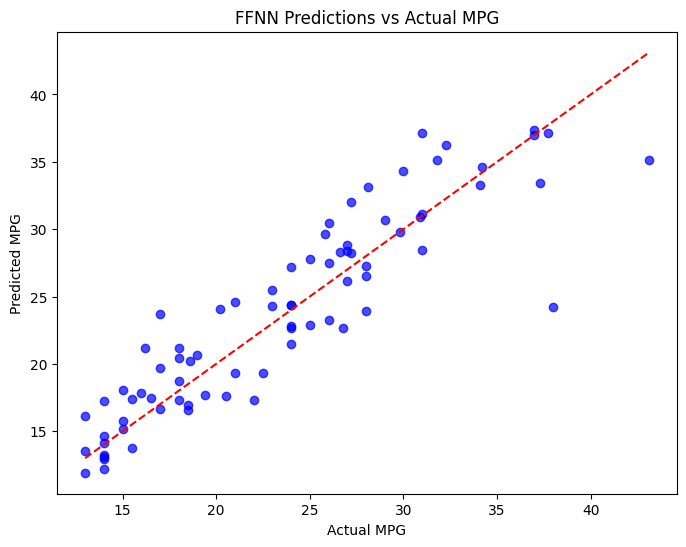

In [8]:
import matplotlib.pyplot as plt

# Best hyperparameters from your results
best_hidden_units = 10
best_epochs = 500
best_lr = 0.0005

# Re-train the best model
nn_best = FFNN(X_train, y_train, best_hidden_units, 1, learning_rate=best_lr)

for epoch in range(best_epochs):
    y_pred = nn_best.forward()
    nn_best.MSE()
    nn_best.backprop()

# Normalize test data and predict
X_test_norm = (X_test - nn_best.X_mean) / nn_best.X_std
nn_best.X = X_test_norm
y_test_pred_norm = nn_best.forward()
y_test_pred = y_test_pred_norm * nn_best.y_std + nn_best.y_mean  # de-normalize

# Plot predicted vs actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("FFNN Predictions vs Actual MPG")
plt.show()
